In [1]:
### required imports

## from anaconda standard lib
import pandas as pd
import numpy as np
import os
import sys
import warnings
import statsmodels.api as sm
from itertools import product

# data vis
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.exceptions import DataConversionWarning

## required installations
import pydot
from tqdm import tqdm

In [2]:
sys.version

'3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]'

In [3]:
# change max display settings to none
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [4]:
# turn off a warning so we can cross-validate easier
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [5]:
# dynamic dataframe class
class ddf(pd.core.frame.DataFrame):
    """ pandas dataframe with two extra methods
        dummy for creating 0/1 binary variables
        impute_na which uses K Nearest Neighbor to fill in NA values
    """
    def dummy(self,col,exclude_values=[],drop_na=False,exclude_na_levels=False,na_levels=np.NaN,keep_original_col=False,sep=":"):
        """ creates dummy (0/1 variable)
            col is the column you want dummied -- will return as many columns as there are unique values in the column so choose carefully
            exclude_values is a lit of values in that column you want ignored when making dummy columns, you can make this your excluded level
            drop_na is if you want null values droped -- if True, will reduce the number of rows in your dataframe
            exclude_na_levels is if you want your na_levels ignored (meaning no dummy will be made for them)
            na_levels is a user-defined NA level (you can tell it what you want considered null, such as "nan")
            keep_original_col -- if False, the column being dummied will disappear
            sep is how you want the new column names separated (new column name will be the old column name + sep + unique value)
        """
        pd.options.mode.chained_assignment = None
        if drop_na == True:
            self = self.loc[self[col].isnull() == False]
        else:
            self[col].loc[self[col].isnull() == True] = na_levels
            if exclude_na_levels == True:
                exclude_values.append(na_levels)

        self[col] = self[col].astype(str)

        for val in self[col].unique():
            if not val in exclude_values:
                self[f'{col}{sep}{val}'] = 0
                self[f'{col}{sep}{val}'].loc[self[col] == val] = 1

        if keep_original_col == False:
            self.drop(columns=[col],inplace=True)

    def impute_na(self,col,exclude=[]):
        """ uses K-nearest neighbors to fill in missing values
            automatically decides which columns (numerics only) to use as predictors
            a better way to do this is Midas, but this is quick and easy
        """
        predictors=[e for e in self.columns if len(self[e].dropna())==len(self[e])] # predictor columns can have no NAs
        predictors=[e for e in predictors if e != col] # predictor columns cannot be the same as the column to impute (this should be taken care of in the line above, but jic)
        predictors=[e for e in predictors if self[e].dtype in (np.int32,np.int64,np.float32,np.float64,int,float)] # predictor columns must be numeric -- good idea to dummify as many columns as possible
        predictors=[e for e in predictors if e not in exclude] # manually exclude columns (like a dep var)
        clf = KNeighborsClassifier(3, weights='distance')

        df_complete = self.loc[self[col].isnull()==False]
        df_nulls = self.loc[self[col].isnull()]

        trained_model = clf.fit(df_complete[predictors],df_complete[col])
        imputed_values = trained_model.predict(df_nulls[predictors])
        df_nulls[col] = imputed_values

        self[col] = df_complete[col].append(df_nulls[col],ignore_index=False) # preserve index order

    def dummy_regex(self,col,regex_expr=[],sep=':r:'):
        """ this creates a dummy (0/1) variable based on if given phrases (regex_expr) is in the col
            regex_expr should be list type
            sep is how the new column name will be separated
        """
        self[col+sep+'|'.join(regex_expr)] = self[col].astype(str).str.contains('|'.join(regex_expr)).astype(int)

## Read Data

In [8]:
# download data directly from github online and save output locally
data = pd.read_csv('data.csv')

In [9]:
# view data
data.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


In [10]:
# subset down to black and white race only
data = data.loc[data['race'].isin(['W','B'])].reset_index(drop=True)

In [11]:
# read in output from the R script that scraped the census data using a wikipedia table's xpath
statewide_race = pd.read_csv('statewide_race_data.csv',encoding='cp437')

# rename the columns to correct for R's default naming conventions
for col in statewide_race.columns:
    if 'X..' in col:
        statewide_race.rename(columns={col:col.lstrip('X..')},inplace=True)

# view output
statewide_race.head()

,State.Territory,Pop.1990,pop1990,Pop.2000,pop2000,Pop.2010,pop2010,Pop.2012,pop2012,growth.2000.2012,pop1990.2012,state_abb
0,Alabama,"2,960,167",73.3%,"3,125,819",70.3%,"3,204,402",67.0%,"3,212,468",66.6%,+2.8%,-6.7 pp,AL
1,Alaska,"406,722",73.9%,"423,788",67.6%,"455,320",64.1%,"460,453",63.0%,+8.7%,-10.9 pp,AK
2,Arizona,"2,626,185",71.7%,"3,274,258",63.8%,"3,695,647",57.8%,"3,730,370",56.9%,+13.9%,-14.8 pp,AZ
3,Arkansas,"1,933,082",82.2%,"2,100,135",78.6%,"2,173,469",74.5%,"2,179,168",73.9%,+3.8%,-8.3 pp,AR
4,California,"17,029,126",57.2%,"15,816,790",46.7%,"14,956,253",40.1%,"14,904,055",39.2%,-5.8%,-18.0 pp,CA


## Prepare Data for Descriptive Analysis

In [12]:
# merge the dataframes -- everything on the left gets state demographic info from df on the right
data['state_percent_white'] = data.merge(statewide_race,how='left',left_on='state',right_on='state_abb')['pop2012']\
                                .apply(lambda x: float(x[:-1]))
                                                                                                         
# match back state name
data['State Name'] = data.merge(statewide_race,how='left',left_on='state',right_on='state_abb')['State.Territory']

In [13]:
# view the dataframe's parameters (rows x cols)
data.shape

(3496, 16)

In [14]:
# see how many columns are missing data
for col in data.columns:
    print(f'missing data in {col}:',len(data) - len(data[col].dropna()))

missing data in id: 0
missing data in name: 0
missing data in date: 0
missing data in manner_of_death: 0
missing data in armed: 174
missing data in age: 49
missing data in gender: 1
missing data in race: 0
missing data in city: 0
missing data in state: 0
missing data in signs_of_mental_illness: 0
missing data in threat_level: 0
missing data in flee: 139
missing data in body_camera: 0
missing data in state_percent_white: 0
missing data in State Name: 0


In [15]:
# if it was undetermined if the suspect is armed, that can be a variable class
data['armed'].fillna('undetermined',inplace=True)

In [16]:
print(data.loc[data['gender'].isnull()]['name'])

# I looked up this case and it was a suicide - can remove from dataset
data = data.loc[data['gender'].isnull() == False]

1963    Scout Schultz
Name: name, dtype: object


## Descriptive Analysis

In [17]:
# look at black/white breakdown on a statewide level
pivot_tbl = pd.pivot_table(data,index='State Name',values='state',columns=['race'],aggfunc='size',fill_value=0)
pivot_tbl['killed percent white'] = round(pivot_tbl['W']/(pivot_tbl['W'] + pivot_tbl['B']) * 100, 2)
pivot_tbl = pivot_tbl.reset_index()
pivot_tbl['in state percent white'] = pivot_tbl.merge(data[['State Name','state_percent_white']].drop_duplicates()
                                                      ,how='left',on='State Name')['state_percent_white']
pivot_tbl['ratio killed:in state'] = round(pivot_tbl['killed percent white'] / pivot_tbl['in state percent white']*100,2)
pivot_tbl.sort_values('ratio killed:in state').reset_index(drop=True).to_csv('states_ratio.csv',index=False)

In [18]:
# five states most likely to see blacks killed
pivot_tbl.sort_values('ratio killed:in state').head(5)

race,State Name,B,W,killed percent white,in state percent white,ratio killed:in state
8,District of Columbia,12,1,7.69,35.3,21.78
39,Rhode Island,2,1,33.33,75.4,44.20
13,Illinois,57,28,32.94,62.9,52.37
18,Louisiana,56,36,39.13,59.7,65.54
20,Maryland,43,24,35.82,53.8,66.58


In [19]:
# five states most likely to see whites killed
pivot_tbl.sort_values('ratio killed:in state').tail(5)

race,State Name,B,W,killed percent white,in state percent white,ratio killed:in state
43,Texas,90,162,64.29,44.3,145.12
2,Arizona,16,104,86.67,56.9,152.32
4,California,118,203,63.24,39.2,161.33
31,New Mexico,1,24,96.00,39.7,241.81
11,Hawaii,1,3,75.00,22.8,328.95


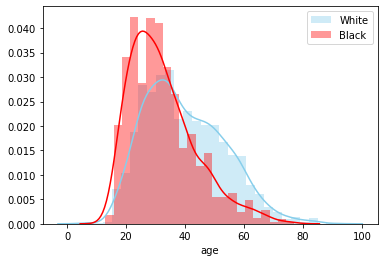

In [20]:
# Histogram of Age by Race
sns.distplot(data.dropna(subset=['age']).loc[data['race'] == 'W', "age"], color="skyblue", label="White")
sns.distplot(data.dropna(subset=['age']).loc[data['race'] == 'B', "age"], color="red", label="Black")
plt.legend(labels=['White','Black'])
plt.savefig('img/age_histogram')

C:\Users\uger7\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

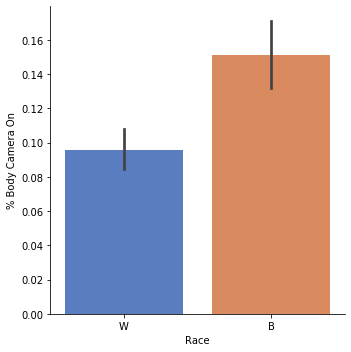

In [21]:
fig = plt.figure()
sns.factorplot(x='race', y='body_camera', data=data, kind='bar',palette='muted').set(xlabel='Race', ylabel='% Body Camera On')
plt.savefig('img/body_camera_boxplot')

## Prepare Data for Modeling

In [22]:
# change from True/False to 0/1
data['body_camera'] = data['body_camera'].astype(int)
data['signs_of_mental_illness'] = data['signs_of_mental_illness'].astype(int)

In [23]:
# use dynamic dataframe processing
data_processed = ddf(data)
# dummy variables
data_processed.dummy('race',exclude_values=['W'])
data_processed.dummy('gender',exclude_values=['F'])
data_processed.dummy('flee',exclude_na_levels=True,na_levels='nan')
data_processed.dummy('threat_level',exclude_values=['undetermined'])

# dummy variables using regex
data_processed.dummy_regex('armed',['gun'])
data_processed.dummy_regex('armed',['unarmed'])

# impute missing age data 
data_processed.impute_na('age',exclude='race:B')
# bucket age into classes (less than 15, 16 to 25, and 26 to 45; over 45 is the omitted class)
data_processed['child'] = data_processed['age'].apply(lambda x: x <= 15).astype(int)
data_processed['young adult'] = data_processed['age'].apply(lambda x: (x > 15) & (x <= 25)).astype(int)
data_processed['adult'] = data_processed['age'].apply(lambda x: (x > 25) & (x <= 45)).astype(int)

# bucket state demographic info (more than 75% white and 50% to 75% white; less than 50% white is the omitted class)
data_processed['state:almost_all_white'] = data_processed['state_percent_white'].apply(lambda x: x > 75).astype(int)
data_processed['state:majority_white'] = data_processed['state_percent_white'].apply(lambda x: (x >= 50) & (x <= 75)).astype(int)

# now that everyting is a binary 0/1 var, drop all non-integer data types
data_processed.drop(columns=['age','id','state_percent_white'],inplace=True)
for col in data_processed:
    if data_processed[col].dtype not in (np.int32,np.int64,int):
        data_processed.drop(columns=col,inplace=True)

In [24]:
# view output
data_processed.head()

,signs_of_mental_illness,body_camera,race:B,gender:M,flee:Not fleeing,flee:Car,flee:Foot,flee:Other,threat_level:attack,threat_level:other,armed:r:gun,armed:r:unarmed,child,young adult,adult,state:almost_all_white,state:majority_white
0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0
1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0
2,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1
3,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,1,0
4,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0


In [25]:
# view shape (rows x cols)
data_processed.shape

(3495, 17)

## Split Data

In [26]:
# split 80% of data into training set
X = data_processed.loc[:,data_processed.columns!='race:B']
y = data_processed.loc[:,data_processed.columns=='race:B']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=20)

## Logistic Model

### Train

In [27]:
# create a logit model with coefficient calculations

# first, copy the dataset and create an intercept variable
X_train2 = X_train.copy()
X_train2['intercept'] = 1

# now, build the model and view the summary stats
logit_model = sm.Logit(y_train,X_train2)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.586618
         Iterations 6
                            Results: Logit
Model:                Logit              Pseudo R-squared:   0.088     
Dependent Variable:   race:B             AIC:                3314.3656 
Date:                 2020-04-21 12:08   BIC:                3415.2766 
No. Observations:     2796               Log-Likelihood:     -1640.2   
Df Model:             16                 LL-Null:            -1797.8   
Df Residuals:         2779               LLR p-value:        1.7292e-57
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
signs_of_mental_illness -0.7134   0.1109 -6.4317 0.0000 -0.9308

In [28]:
# fit the same
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Predict

In [29]:
# create predictions
y_pred_logit = logreg.predict(X_test)

In [30]:
# confusion matrix
confusion_matrix(y_test,y_pred_logit)

array([[403,  45],
       [166,  85]], dtype=int64)

In [31]:
# no information rate
no_info_rate = round(1 - len(y_test.loc[y_test['race:B'] == 1])/len(y_test),2)
print('No Information Rate:', no_info_rate)
print('Model Total Accruacy:',round((1-np.sum(abs(y_pred_logit-y_test[y_test.columns[0]]))/len(y_test)),2))

No Information Rate: 0.64
Model Total Accruacy: 0.7


In [32]:
# classification report
print(classification_report(y_test,y_pred_logit))

              precision    recall  f1-score   support

           0       0.71      0.90      0.79       448
           1       0.65      0.34      0.45       251

    accuracy                           0.70       699
   macro avg       0.68      0.62      0.62       699
weighted avg       0.69      0.70      0.67       699



### Visualize

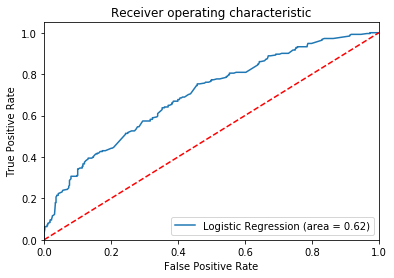

In [33]:
# ROC Curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('img/Log_ROC')
plt.rcParams["figure.figsize"] = (10,5)
plt.show()

## Random Forest

### Hyper Tune

In [34]:
# Random Forest Classifier
hyper_params = {
    'max_depth':[10,20],
    'n_estimators':[100,500,1000],
    'min_samples_split':[2,4,6],
    'max_features':['auto','sqrt'],
    'max_samples':[0.5,.99]
}

# expand grid to get all possible combos
def expand_grid(dictionary):
    """ takes a dictionary of lists, and expands out arrays into a pandas dataframe
    """
    return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns=dictionary.keys())
grid = expand_grid(hyper_params)

# view result shape
grid.shape

(72, 5)

In [35]:
# create cross validate function
def cross_validate_rf(X_train,y_train,k=3,grid=grid,loss='gini'):
    """ cross validates across k folds
        uses non-sepcified random states, so results can change each time
        returns two outputs: the optimal hyperparameters and the full grid with derived error metrics
    """
    # copy our grid to write error metrics into it
    hyper_grid = grid.copy()
    
    # create the error columns for each cross-validation fold
    for i in range(1,k+1):
        hyper_grid[f'error_{i}'] = 0
    
    # run the random forest estimator through the gird of parameters and score each cv fold
    for i, row in tqdm(hyper_grid.iterrows()):
        rf = RandomForestClassifier(
            n_estimators = row['n_estimators'],
            max_depth = row['max_depth'],
            min_samples_split = row['min_samples_split'],
            max_features = row['max_features'],
            max_samples = row['max_samples']
        )
        errors = 1 - cross_val_score(rf, X_train, y_train, cv=k, scoring = 'accuracy')
        # write each cv score to its own column
        for idx, e in enumerate(errors):
            hyper_grid.loc[hyper_grid.index==i,f'error_{idx+1}'] = e
    # take the mean of each cross-validated iteration to get the final error metric for each line of hyper parameters
    hyper_grid['total_error'] = hyper_grid[[e for e in hyper_grid.columns if e.startswith('error_')]].mean(axis=1)
    min_error = hyper_grid['total_error'].min()
    # return the row with the lowest error metric as well as the full set of results
    return hyper_grid.loc[hyper_grid['total_error'] == min_error], hyper_grid

In [36]:
# hyper tune parameters with 3-fold cv
hyper_tuned_metrics, full_cv_results = cross_validate_rf(X_train,y_train)

72it [08:06,  6.76s/it]


In [37]:
# view best metrics
hyper_tuned_metrics

,max_depth,n_estimators,min_samples_split,max_features,max_samples,error_1,error_2,error_3,total_error
10,10,100,6,sqrt,0.5,0.315451,0.30794,0.322961,0.315451


### Train

In [38]:
# define the model based on the parameters in the above grid
rf = RandomForestClassifier(
            max_depth = 10,
            n_estimators = 100,
            min_samples_split = 6,
            max_features = 'sqrt',
            max_samples = .5,
        random_state=20)
# train model on full training set
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=0.5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

### Predict

In [39]:
# predictions from RF model
y_pred_rf = rf.predict(X_test)
error = np.sum(abs(y_pred_rf-y_test[y_test.columns[0]]))/len(y_test)

# Look at accuracy vs. no-information rate
print('No information rate:', no_info_rate)
print('Total accuracy of model:', round(1-error, 2))

No information rate: 0.64
Total accuracy of model: 0.68


In [40]:
# classification report
print(classification_report(y_test,np.round(y_pred_rf,0)))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78       448
           1       0.61      0.33      0.42       251

    accuracy                           0.68       699
   macro avg       0.65      0.60      0.60       699
weighted avg       0.67      0.68      0.65       699



### Visualize

In [41]:
# big tree visualizations
tree = rf.estimators_[5]
export_graphviz(tree, out_file = 'img/tree.dot', feature_names = X_train.columns.to_list(), rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('img/tree.dot')
graph.write_png('img/tree.png')

In [42]:
# small tree visualizations
rf_small = RandomForestClassifier(n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)
tree_small = rf_small.estimators_[5]
export_graphviz(tree_small, out_file = 'img/small_tree.dot', feature_names = X_train.columns.to_list(), rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('img/small_tree.dot')
graph.write_png('img/small_tree.png')

In [43]:
# feature importances
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns.to_list(), importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
['Variable: {:20} Importance: {}'.format(*pair) for pair in feature_importances]

['Variable: young adult          Importance: 0.15',
 'Variable: signs_of_mental_illness Importance: 0.1',
 'Variable: armed:r:gun          Importance: 0.09',
 'Variable: adult                Importance: 0.09',
 'Variable: body_camera          Importance: 0.08',
 'Variable: flee:Foot            Importance: 0.06',
 'Variable: state:almost_all_white Importance: 0.06',
 'Variable: state:majority_white Importance: 0.06',
 'Variable: flee:Not fleeing     Importance: 0.05',
 'Variable: threat_level:attack  Importance: 0.05',
 'Variable: threat_level:other   Importance: 0.05',
 'Variable: armed:r:unarmed      Importance: 0.05',
 'Variable: gender:M             Importance: 0.04',
 'Variable: flee:Car             Importance: 0.03',
 'Variable: flee:Other           Importance: 0.02',
 'Variable: child                Importance: 0.01']

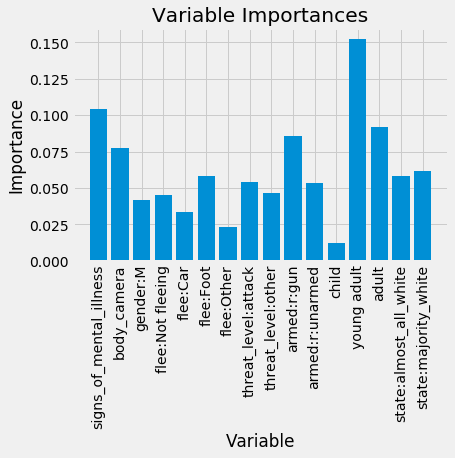

In [44]:
# feature importance vis
%matplotlib inline
plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, X_train.columns.to_list(), rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.savefig('img/feature_importance.png')